Pour l'instant les recherches s'effectuent sur le train set uniquement


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Cours/MA3/ML7/ML_course/projects/project1/Project1_final

/content/drive/MyDrive/Cours/MA3/ML7/ML_course/projects/project1/Project1_final


In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from implementations import *
from preprocessing import *
from crossvalidation import *
from helpers_p1 import *
from tools import *
%load_ext autoreload
%autoreload 2

# Loading 


In [4]:

# Loading the data

train_data_raw = np.genfromtxt("data/train.csv", delimiter=',', dtype=None, encoding=None) #dtype=None pour recupérer les string de prediction (sinon ça devient des Nan))
test_data_raw = np.genfromtxt("data/test.csv", delimiter=',', dtype=None, encoding=None) #dtype=None pour recupérer les string de prediction (sinon ça devient des Nan))


# Preprocessing


In [5]:

# Preprocessing the data

nbr_jet = 4
undef = np.float64(-999.0)
pred_dict = {'s':'1','b':'0', '?':'-1'}

# Save raw data
train_data = train_data_raw.copy()
test_data = test_data_raw.copy()

# drop 1st row with column names ("[1:,") 
train_data = train_data[1:, :]
test_data_raw = test_data_raw[1:, :] 

# Change s(signal) and b(background) for s:1 and b:0, and change '?' for -1
train_data[:,1] = np.vectorize(pred_dict.get)(train_data[:,1].astype(str))
test_data[:,1] = np.vectorize(pred_dict.get)(test_data[:,1].astype(str))

# Divide the dataset in four according to PRI_jet_num feature and cast to float
train_data_jets = divide_dataset_by_jet(train_data)
test_data_jets = divide_dataset_by_jet(test_data)

# Remove columns with nan values or with standard deviation of 0
test_data_jets, train_data_jets = clean_features(test_data_jets, train_data_jets, undef)

# Standardize train and test sets to have mean=0 and std=1
train_data_jets, test_data_jets = standardize(train_data_jets, test_data_jets)

# Replace remaining undefined values by mean, median or zero
train_data_mean, train_data_median, train_data_null = replace_nan(train_data_jets)
test_data_mean, test_data_median, test_data_null = replace_nan(test_data_jets)



In [6]:
# Save previous data
train_data_median_pca = train_data_median.copy()
test_data_median_pca = test_data_median.copy()
train_data_mean_pca = train_data_mean.copy()
test_data_mean_pca = test_data_mean.copy()


# Principal Component Analysis

In [131]:

## Principal Component Analysis

# The goal was to lower the dimension of the feature space by using principal components explaining 95% of the dataset's variance
# It was not used because predictions were not better than with original features

nbr_jet = 4

for jet in range(nbr_jet):

    train_standardized = train_data_mean_pca[jet][:,1:]
    train_pred = train_data_mean_pca[jet][:,0] #Prediction column

    # Covar matrix
    covariance_matrix = np.cov(train_standardized.T)

    # Eigenvectors decomposition 
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

    # Calculating the explained variance on each of components
    variance_explained = []
    for i in eigen_values:
         variance_explained.append((i/sum(eigen_values))*100)

    # Identifying components that explain at least 95%
    cumulative_variance_explained = np.cumsum(variance_explained)
    
    # Get the number of PCA component that explain at least 95% of the variance
    nbr_pca_component = np.sum(cumulative_variance_explained < 95) + 1
    
    # Using nbr_pca_component components that explain 95% of the variance
    projection_matrix = (eigen_vectors.T[:][:nbr_pca_component]).T

    # Getting the product of original standardized X and the eigenvectors
    # Correspond to the new dataset and new features
    train_data_mean_pca[jet] = train_standardized.dot(projection_matrix)

    # re-insert prediction column
    train_data_mean_pca[jet] = np.insert(train_data_mean_pca[jet], 0, list(train_pred), axis=1)


# GridSearch for best Model

In [ ]:
### GridSearch for the best model for ridge regression 

nbr_jet = 1
lambdas = np.logspace(-4, 0, 5) #5 values btw 1e-4 and 1
degree = 15
k_fold = 5
seed = 6
method = ridge_regression
acronym = 'RR'

train_data_jets = train_data_mean.copy()

plot_values = []


for jet in range(nbr_jet):
    # Actual dataset used for the current jet
    train_data_jet = train_data_jets[jet]
    accuracies = []
    
    # Grid search start
    for deg in range(1, degree+1):
        for lambda_ in lambdas:
            # K-folds Cross validation with K=5
            accuracy =  cross_validation(train_data_jet[:, 1:], acronym, method, seed=seed, k_fold=k_fold, deg=deg, lambda_=lambda_)
            plot_values.append([jet, deg, lambda_, accuracy])
            accuracies.append([deg, lambda_, accuracy])
            print(f"Done lambda = {lambda_}")
        print("deg: ",deg, end='\r')
    accuracies_np = np.array(accuracies)
    best_model = accuracies_np[np.argmax(accuracies_np[:,2]), 0:3]
    print('jet: ',jet,best_model)


### Plot results of GridSearch on Ridge Regression hyper-parameters

In [1]:
# Creation of axis
plot_np = (np.array(plot_values))[:, 1:]
plot_np = plot_np[(plot_np[:, 0] == 1) | 
        (plot_np[:, 0] == 3) |
        (plot_np[:, 0] == 6) |
        (plot_np[:, 0] == 9) |
        (plot_np[:, 0] == 12) |
        (plot_np[:, 0] == 15)]

NameError: name 'np' is not defined

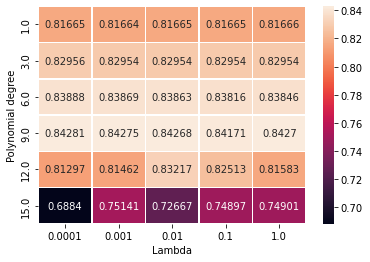

In [79]:
import pandas as pd # Only for visualization
import matplotlib.pyplot as plt

data = pd.DataFrame({'Polynomial degree': plot_np[:, 0], 'Lambda': plot_np[:, 1], 'Z': plot_np[:, 2]})
data_pivoted = data.pivot("Polynomial degree", "Lambda", "Z")
ax = sns.heatmap(data_pivoted, annot=True, fmt='.5g', linewidths=.5)
#plt.show()
plt.savefig('heatmap_jet0.jpg', dpi=600)

# Run the model

In [130]:
!python3 run.py

Loading of the data 

tcmalloc: large alloc 1963835392 bytes == 0x5612513bc000 @  0x7f14f671e001 0x7f14f42dc54f 0x7f14f432cb58 0x7f14f432fe83 0x7f14f433007b 0x7f14f43d1761 0x561214e0e544 0x561214e0e240 0x561214e82627 0x561214e7cced 0x561214e0fbda 0x561214e7e737 0x561214e7c9ee 0x561214e7c6f3 0x561214f464c2 0x561214f4683d 0x561214f466e6 0x561214f1e163 0x561214f1de0c 0x7f14f5506bf7 0x561214f1dcea
Preprocessing of the data 

Training of the weights 

new values yy
0.0001 9
new values yy
0.01 12
new values yy
0.001 12
new values yy
1 12
Computation of the test prediction 

Creation of the submission file 

Submission file created under 'submission.csv'



# GridSearch for all methods and parameters

In [ ]:

### GridSearch for the best model for all methods and parameters (very long)

methods = [least_squares_GD, least_squares_SGD, least_squares, ridge_regression, logistic_regression, reg_logistic_regression]
# Acronyms:  LSGD  LSSGD  LS  RR  LR  RLR
# Flags for method
LS=False #for LS_GD, LS_SGD and logreg because same parameters
RR=False #for Ridge Regression
RLR=False #for reg log reg


train_data_jets = train_data_mean.copy()
nbr_jet = 4
lambdas = np.logspace(-4, 0, 5)
gammas = [ 0.001, 0.005, 0.01, 0.05, 0.1, 0.2] 
max_iterations = [50, 100, 150, 300]
degree = 12
k_fold = 10
seed = 6


for c in range(len(methods)):
    c=0
    method = methods[c]
    LS, RR, RLR, acronym  = set_flags(criterion) 
    print(LS,RR,RLR, acronym)
    for jet in range(nbr_jet):
        # Actual dataset used for the current jet
        train_data_jet = train_data_jets[jet]
        accuracies = []

        # Grid search start
        for deg in range(8, degree+1):
            print("method: {}  jet: {}  deg: {}".format(method,jet,deg), end='\r')
            if (method == least_squares):
                # Least Squares
                with open("best_results.txt", "a+") as external_file: 
                    print("[ Accuracy degree]", file=external_file)
                    external_file.close()
                accuracy =  cross_validation(train_data_jet, acronym, method, seed=seed, k_fold=k_fold, deg=deg)
                accuracies.append([accuracy, deg])
            elif (RR):
                # Ridge Regression
                with open("best_results.txt", "a+") as external_file: 
                    print("[ Accuracy degree lambda_]", file=external_file)
                    external_file.close()
                for lambda_ in lambdas: 
                    accuracy =  cross_validation(train_data_jet, acronym, method, seed, k_fold=k_fold, deg=deg, lambda_=lambda_)
                    accuracies.append([accuracy, deg, lambda_])
            elif (LS):
                # LeastSquares GD or SGD, or Logistic Regression
                with open("best_results.txt", "a+") as external_file: 
                    print("[ Accuracy degree max_iters gamma]", file=external_file)
                    print("write init done")
                    external_file.close()
                for max_iters in max_iterations:
                    for gamma in gammas:
                        print("max_iters:{}  gamma:{}".format(max_iters, gamma), end='\r')
                        accuracy =  cross_validation(train_data_jet, acronym, method, seed, k_fold=k_fold, deg=deg, max_iters=max_iters, gamma=gamma)
                        accuracies.append([accuracy, deg, max_iters, gamma])
            elif (RLR):
                # Regularized Logistic Regression
                with open("best_results.txt", "a+") as external_file: 
                    print("[ Accuracy degree max_iters gamma lambda_]", file=external_file)
                    external_file.close()
                for max_iters in max_iterations:
                    for gamma in gammas:
                        for lambda_ in lambdas:   
                            accuracy =  cross_validation(train_data_jet, acronym, method, seed, k_fold=k_fold, deg=deg, max_iters=max_iters, gamma=gamma, lambda_=lambda_)
                            accuracies.append([accuracy, deg, max_iters, gamma, lambda_])
                
        accuracies_np = np.array(accuracies)
        best_model = accuracies_np[np.argmax(accuracies_np[:,0]), :]
        print('method: ',method,' jet: ',jet,best_model)
        
        with open("best_results.txt", "a+") as external_file:
            print('method: ',method,' jet: ',jet,best_model, file=external_file)
            external_file.close()
